# Продвинутый Python, лекция 12

**Лектор:** Петров Тимур

**Семинаристы:** Бузаев Федор, Дешеулин Олег, Коган Александра, Васина Олеся, Садуллаев Музаффар

##Парсинг

Парсинг - это разговорное название **синтаксического анализа**. Под парсингом в широком смысле этого слова принято понимать последовательный разбор какого-то текста (набора слов / токенов) в соответствии с определенными правилами.

Так, разбор исходного кода на каком-то языке программирование в процессе трансляции - это тоже парсинг. Спарсить можно все, что имеет *определенный синтаксис*. Мы сегодня поговорим о частном случае синтаксического анализа: о парсинге веб-страниц.

##Веб-страница

Когда мы заходим на какую-то веб-страницу, сервер присылает нашему браузеру набор файлов разных форматов. Прежде всего приходит HTML-файл. Вот, например, что отдает сервер Хабра:

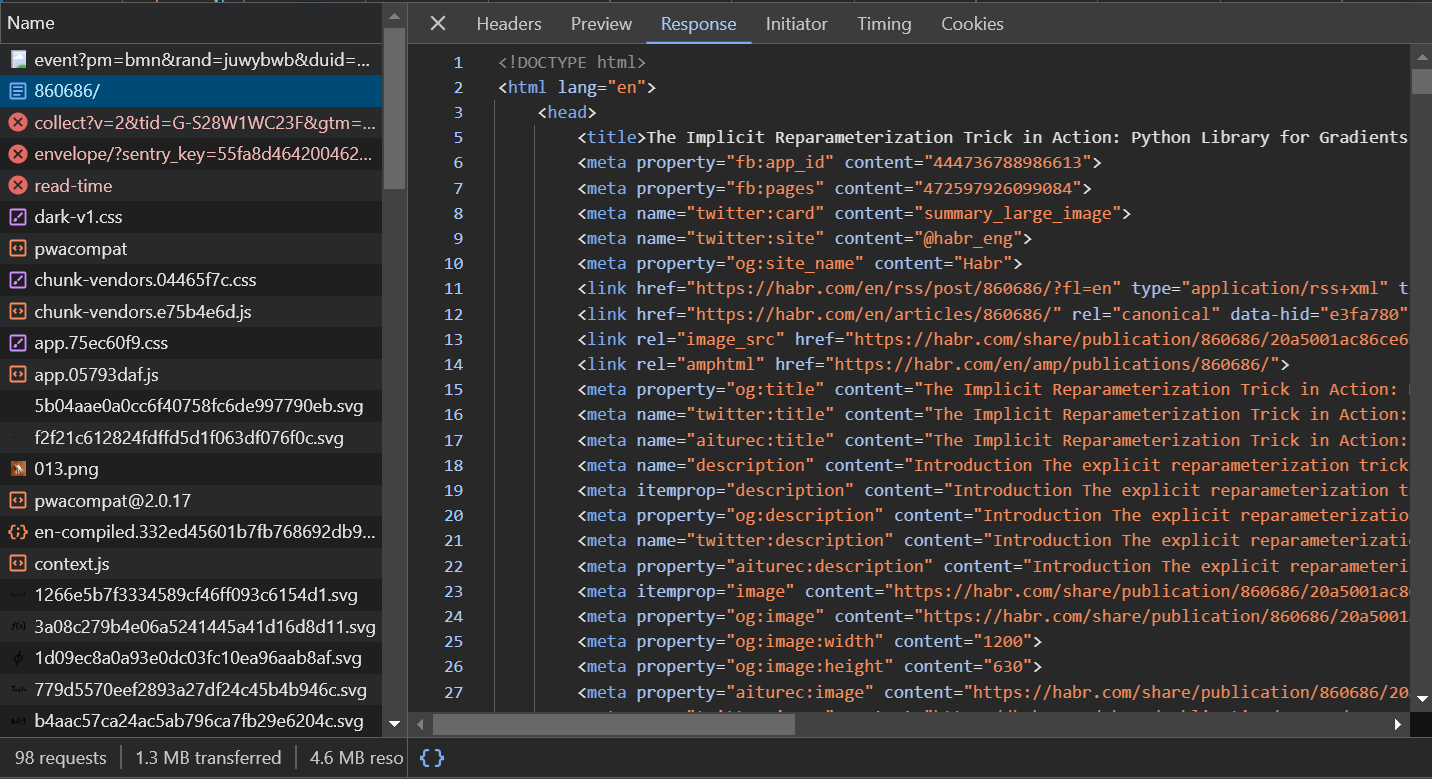

В HTML-файле прописана структура веб-страницы, а также указаны все ресурсы, которые потребуются для ее корректной работы: CSS, JS, PNG / JPEG / SVG, TTF и др. файлы. Браузер делает ряд сетевых запросов, чтобы догрузить содержимое страницы.

Заметим, что HTML, язык гипертекстовой разметки, имеет строгую иерархию: один HTML-тег вложен в другой, а корень всех тегов - **\<html>**. Корень и дети... Да это же дерево! Именно так в памяти компьютера и представлена веб-страница.

##DOM-дерево

**DOM (Document Object Model)** — это объектная модель документа, которую браузер создает в памяти компьютера на основании HTML-кода, полученного им от сервера. Иными словами, это представление HTML-документа в виде дерева тегов. Узлы в таком дереве бывают двух типов: обычные и текстовые. Обычные содержат HTML-теги, а текстовые - информацию внутри тегов.

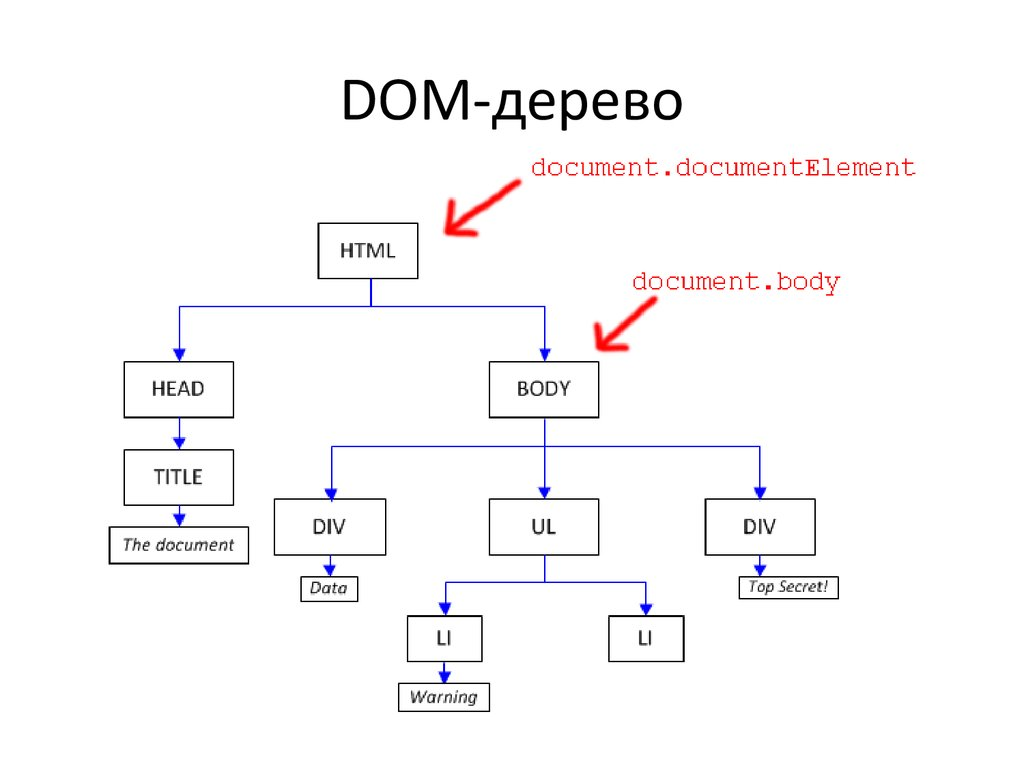

Итак, до каждого элемента на сайте есть путь. А у элементов могут быть атрибуты (class, id, href) и содержимое. Это дерево мы и будем **парсить**, извлекая нужную нам информацию по определенным правилам.

Для того, чтобы найти нужный элемент, можно использовать **CSS-селекторы** или **XPath**. Прочитайте про селекторы и XPath [подробнее](https://docs.scrapy.org/en/latest/topics/selectors.html). Это обширная тема, но вы получите полезный навык, который пригодится вне зависимости от того, какую библиотеку для парсинга вы используете.

##Запускаем паука

Экосистема языка программирования Python богата на разные инструменты для парсинга. Одной из самых удобных и продвинутых библиотек на сегодняшний день является [Scrapy](https://docs.scrapy.org/en/latest/index.html), поддерживающая асинхронный парсинг. Посмотрим на основные концепции этой библиотеки и заодно спарсим всякое-разное из Wiki нашего факультета:

In [ ]:
!pip install scrapy

### 0. Settings

Мы можем настроить наш парсер, чтобы избежать блокировок на сайте, который парсим: например, установить `ROBOTSTXT_OBEY`, `USER_AGENT`, `RANDOMIZE_DOWNLOAD_DELAY`, `CONCURRENT_ITEMS`. Можем ограничить максимальное время ожидания ответа от сервера (таймаут) или максимальный вес скачиваемых файлов. Можем настроить подключение к FTP-серверу или AWS, проксировать запросы и т.д.

В общем, настройки Scrapy действительно тонкие и их много. Конечно, большинство нужно для продвинутого парсинга. В нашем примере мы определим их на уровне паука.

### 1. Items

Для хорошего парсера важно понимать структуру данных, которые мы извлекаем. Именно для этого используются классы `Item` и `Field` из модуля `scrapy.item`. `Item` - это какая-то сущность, например, Product. Ей присущи какие-то интересующие нас атрибуты, например, price и created_date. С помощью `Field` можно определить правила сериализации данных.

In [ ]:
import scrapy

class CourseItem(scrapy.Item):
  name = scrapy.Field()
  link = scrapy.Field()

### 2. Pipeline

Когда мы спарсили item, можно отправить его в pipeline, чтобы как-то обработать. Например, валидировать по особым правилам (price у Product не меньше $1000), записать в JSON-файл или удалить дубликаты. Вы можете придумать любой сценарий и реализовать его в pipeline.

In [ ]:
import csv

class HSEPipeline:
  def open_spider(self, spider):
    self.file = open('courses.csv', 'w', newline='', encoding='utf-8')
    self.writer = csv.writer(self.file)
    self.writer.writerow(['Название', 'Ссылка'])

  def close_spider(self, spider):
    self.file.close()

  def process_item(self, item, spider):
    self.writer.writerow([item['name'], item['link']])
    return item

### 3. Spiders

Spiders - это классы, в которых определяется логика поведения парсера: куда ему идти, как и что извлекать. Ваш spider будет наследоваться от `scrapy.Spider`. В документации вы можете найти полный перечень атрибутов и методов, которые определены в классе. В модуле `scrapy.spiders` вы также найдете полезных специальных пауков: `CrawlSpider`, `XMLFeedSpider`, `CSVFeedSpider` и `SitemapSpider`.

In [ ]:
class HSESpider(scrapy.Spider):
  name = "cs_wiki_parser"
  start_urls = ['http://wiki.cs.hse.ru/Заглавная_страница']
  custom_settings = {
      'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
      'DOWNLOAD_DELAY': 1,
      'ITEM_PIPELINES': {
        '__main__.HSEPipeline': 300,
      }
  }

  def parse(self, response):
    rows = response.xpath("//table[@class='wikitable'][1]//tr[2]")
    for row in rows:
      links = row.xpath(".//td//a")
      for link in links:
        item = CourseItem()
        item['name'] = link.xpath("text()").get()
        item['link'] = response.urljoin(link.xpath("@href").get())
        yield item

In [ ]:
from scrapy.crawler import CrawlerProcess

process = CrawlerProcess()
process.crawl(HSESpider)
process.start()

INFO:scrapy.utils.log:Scrapy 2.12.0 started (bot: scrapybot)
2024-11-23 10:00:14 [scrapy.utils.log] INFO: Scrapy 2.12.0 started (bot: scrapybot)
INFO:scrapy.utils.log:Versions: lxml 5.3.0.0, libxml2 2.12.9, cssselect 1.2.0, parsel 1.9.1, w3lib 2.2.1, Twisted 24.10.0, Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0], pyOpenSSL 24.2.1 (OpenSSL 3.3.2 3 Sep 2024), cryptography 43.0.3, Platform Linux-6.1.85+-x86_64-with-glibc2.35
2024-11-23 10:00:14 [scrapy.utils.log] INFO: Versions: lxml 5.3.0.0, libxml2 2.12.9, cssselect 1.2.0, parsel 1.9.1, w3lib 2.2.1, Twisted 24.10.0, Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0], pyOpenSSL 24.2.1 (OpenSSL 3.3.2 3 Sep 2024), cryptography 43.0.3, Platform Linux-6.1.85+-x86_64-with-glibc2.35
INFO:scrapy.addons:Enabled addons:
[]
2024-11-23 10:00:14 [scrapy.addons] INFO: Enabled addons:
[]
DEBUG:scrapy.utils.log:Using reactor: twisted.internet.epollreactor.EPollReactor
2024-11-23 10:00:15 [scrapy.utils.log] DEBUG: Using reactor: twist

Порефлексируем, что мы сделали:

1. Определили, какие данные хотим забрать с веб-страницы. В данном случае это курсы бакалавриата ФКН.
2. Описали контракт данных: в классе `CourseItem` есть два атрибута `name` и `link`.
3. Создали pipeline для обработки данных. При запуске паука он открывает файл `courses.csv` и записывает туда строку `Название,Ссылка`. При завершении работы паука он закрывает файл. В процессе работы паука он получает от него каждый новый item и записывает в файл.
4. Создали паука для сбора данных. Определили метод `parse`, который находит в HTML нужную нам таблицу, формирует из каждой ссылки в нужной нам ячейке item и отдает его в pipeline (`yield item`).

В результате мы получаем CSV файл с ссылками на курсы бакалавриата ФКН:

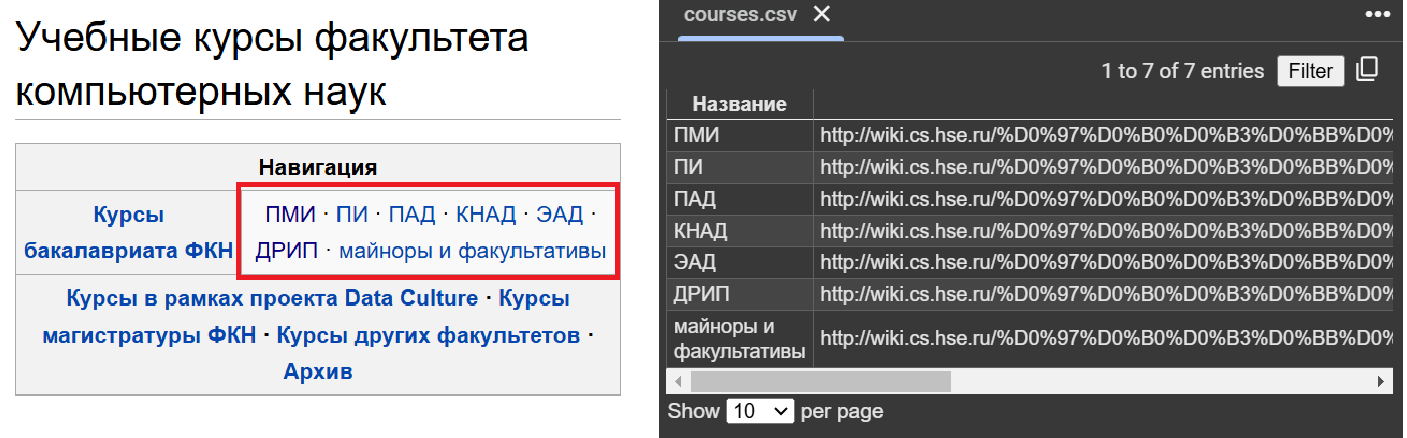

Есть и другие концепции: `Selectors`, `Feed Exports`, `Link Extractors`, а также важные расширения для продвинутого парсинга: `Middlewares`, `Add-ons`, `Signals`. Подробнее вы можете узнать в документации.

##Полный привет

Изучили документацию, потренировались. Теперь мы эксперты в Scrapy и умеем писать промышленные парсеры. Представим, что нам поступило задание спарсить очередной сайт. Открываем пришедший от сервера HTML-файл, а там...



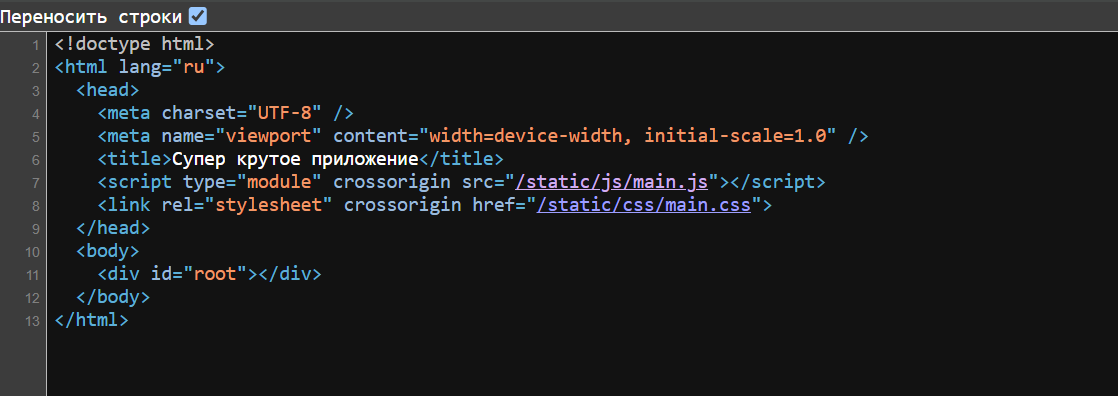

В браузере перед нашими глазами полноценный сайт, а вот содержимое HTML-документа точно ему не соответствует. Мы имеем дело с **динамической веб-страницей**, которая использует JavaScript для манипулирования содержимым.

Получив такой HTML-файл от сервера, браузер подгружает и выполняет `main.js`. Именно в этом файле содержатся инструкции, как построить дерево HTML-тегов, поэтому мы не сможем получить к нему доступ с помощью Scrapy.

Данные, которые появляются на сайте в процессе *рендеринга*, не берутся из ниоткуда. Часть из них сразу поставляется внутри JS-файлов, а часть подгружается по сети.

### 1. Данные по API

Например, сайт Ostrovok при загрузке делает ряд запросов к API, чтобы получить динамически отображаемое содержимое страницы. Список "популярных направлений" приходит в JSON-формате от эндпоинта
https://ostrovok.ru/hotel/api/seo/v2/homepage/. Если мы хотим спарсить популярные направления на Островке, то можем сделать GET-запрос и извлечь интересующие нас данные: страну, название, картинку, полезные ссылки направлений.

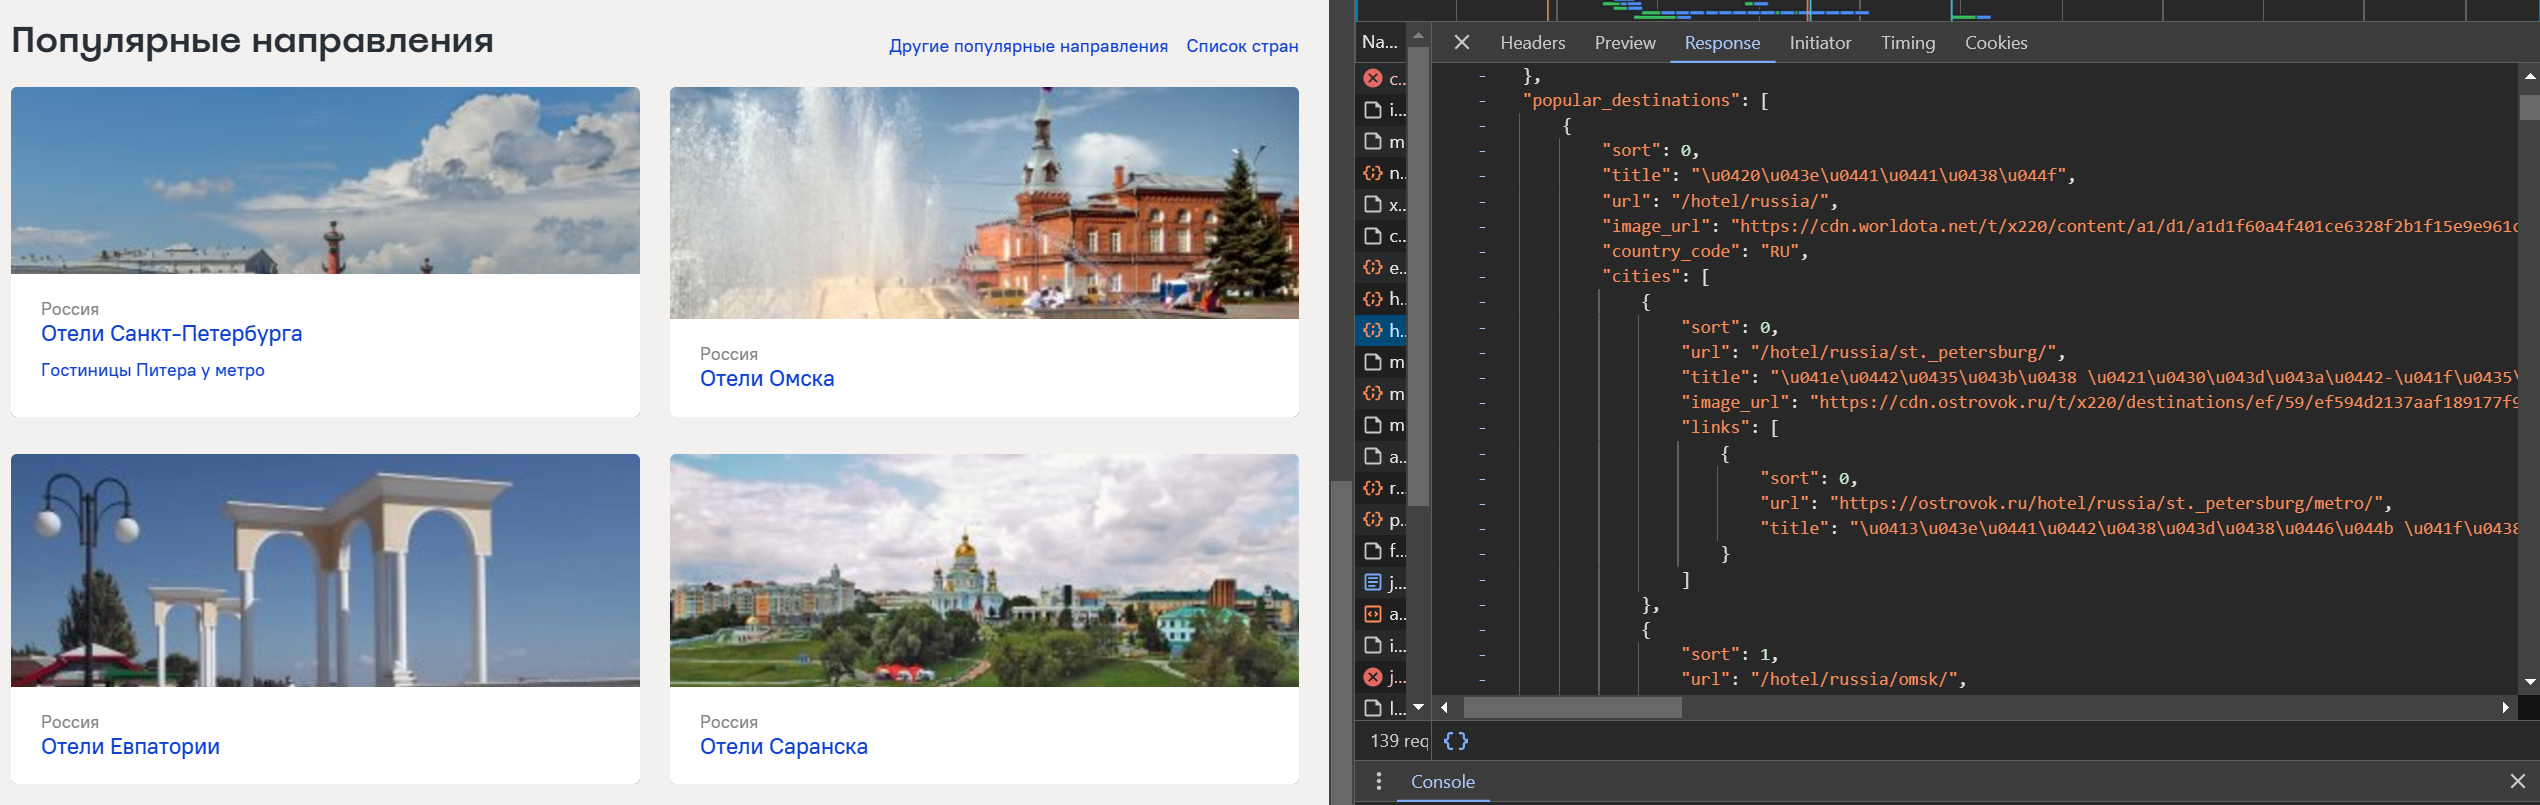

In [ ]:
from dataclasses import fields

def save_dataclass_to_csv(
  objs: Generator[object, None, None],
  filename: str,
  headings: list[str],
):
  """Сохраняет список объектов в CSV-файл"""
  with open(filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(headings)
    for obj in objs:
      writer.writerow([getattr(obj, field.name) for field in fields(obj)])

In [ ]:
import requests
import csv
from dataclasses import dataclass
from typing import Generator

@dataclass
class Destination:
    name: str
    country: str
    url: str
    sort: int

def fetch_popular_destinations(url: str) -> Generator[Destination, None, None]:
  """Извлекает популярные направления на Островке и возвращает генератор объектов Destination"""
  response = requests.get(url)
  response.raise_for_status()
  data = response.json()

  for country in data.get('popular_destinations', []):
    country_name = country.get('title')
    for city in country.get('cities', []):
      city_name = city.get('title')
      link = 'https://ostrovok.ru' + city.get('url')
      sort_order = city.get('sort')
      yield Destination(
          name=city_name,
          country=country_name,
          url=link,
          sort=sort_order
      )

ENDPOINT_URL = 'https://ostrovok.ru/hotel/api/seo/v2/homepage/'
destinations = fetch_popular_destinations(ENDPOINT_URL)
save_dataclass_to_csv(destinations, 'destinations.csv', ['Название', 'Страна', 'Ссылка', 'Порядок'])

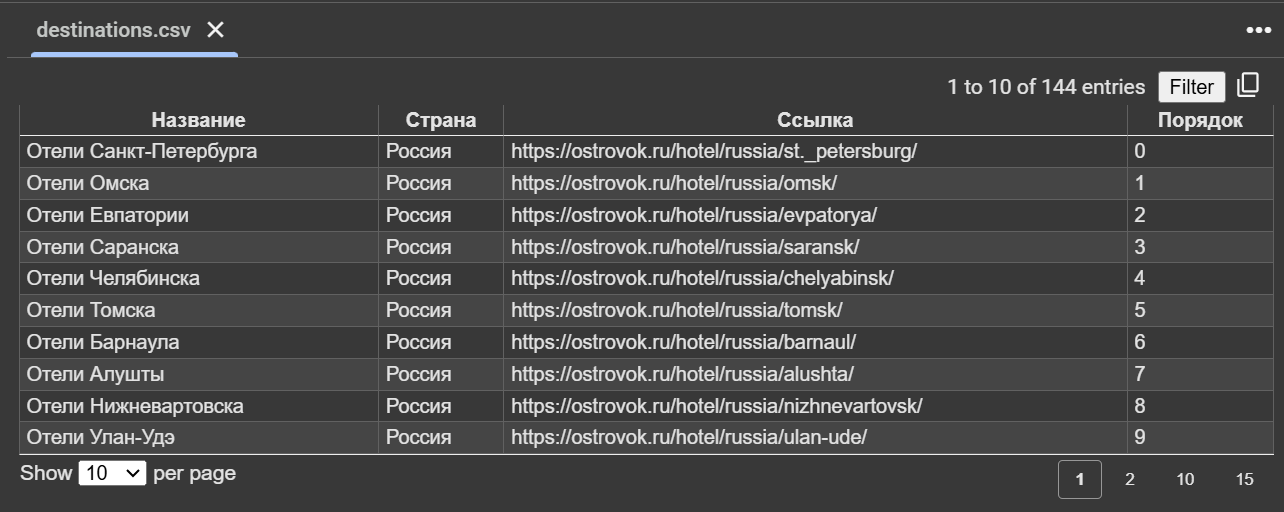

Процесс парсинга, описанный в коде выше, похож на парсинг с помощью Scrapy. Мы также опредилили упрощенные контракт данных (item), функция для извлечения данных из объекта по ссылке (spider), функция для сохранения данных в CSV-файл (pipeline).

Неспроста все эти абстракции были формализованы в Scrapy 😀

### 2. Данные внутри JS

Представим, что мы хотим спарсить меню на Островке. Его нет в HTML-документе и по API меню тоже не приходит. Оно приходит внутри JS-файла:

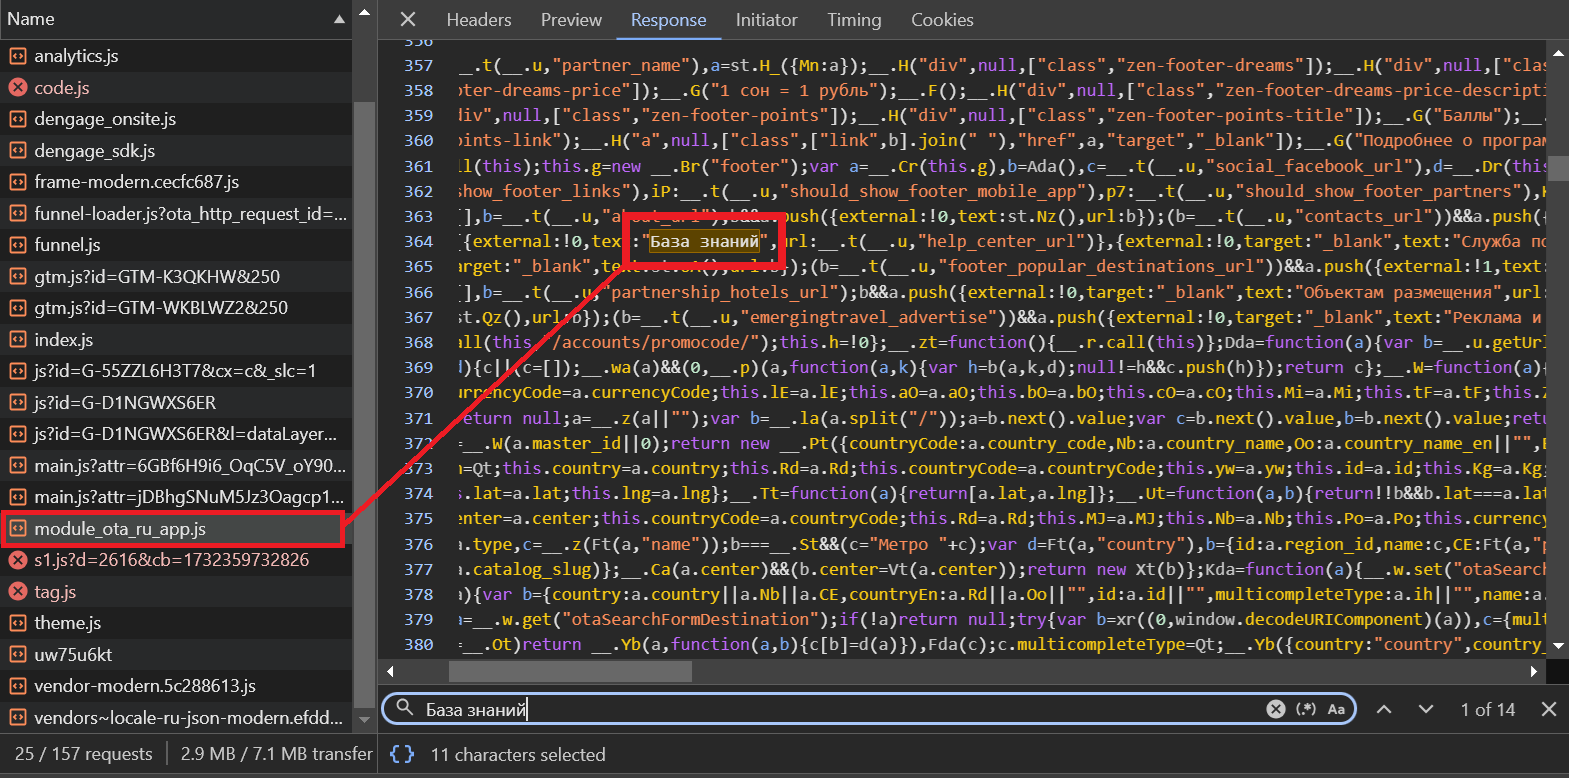

Нам точно не хочется разбираться с этим. Более того, не всегда удобно парсить множество внешних сетевых запросов, которые отправляет сайт, чтобы получить данные. Было бы удобно написать инструкции, чтобы извлекать данные с сайта так, как мы их видим **непосредственно в браузере** после полного рендеринга страницы.

##Симулируем браузер

Используя библиотеку [Selenium](https://selenium-python.readthedocs.io/), мы можем написать парсер, который будет иметь доступ к динамически построенному DOM-дереву так, как мы сами имеем к нему доступ в "Просмотре кода элемента", когда сайт полностью загрузился. Это возможно, потому что парсер не работает с полученными от сервера файлами, а способен "дожидаться" определенных событий и выполнять интерактивные действия.

*Стоит оговориться, что Selenium предназначается не столько для парсинга, сколько для автоматического тестирования фронтенда. Парсинг с ним может быть медленным. Стоит применять его в тех случаях, когда более быстрые и менее затратные подходы, как Scrapy или прямое обращение к API ресурса, по каким-то причинам бессильны.*

In [ ]:
# Установка Chrome в Google Colab

!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get install -f

--2024-11-24 09:34:58--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 172.253.115.91, 172.253.115.93, 172.253.115.190, ...
Connecting to dl.google.com (dl.google.com)|172.253.115.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112363312 (107M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>] 107.16M   232MB/s    in 0.5s    

2024-11-24 09:34:58 (232 MB/s) - ‘google-chrome-stable_current_amd64.deb’ saved [112363312/112363312]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (131.0.6778.85-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libvulkan1; however:
  Package

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 34.4 MB/s eta 0:00:00


In [ ]:
!pip install webdriver_manager

### 0. WebDriver

Основной компонент Selenium, позволяющий программно управлять браузером. В общем случае он буквально открывает браузер и выполняет в нем заданные инструкции, а вы можете за этим наблюдать. Однако поддерживается работа в `headless` режиме, "на фоне". WebDriver очень гибкий и поддерживает Chrome, Firefox, Safari и др. браузеры. Парсер на Selenium начинается с **веб-драйвера**!

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

class WebDriver:
  """Контекстный менеджер для управления WebDriver"""
  def __init__(self):
    self.driver = None

  def __enter__(self):
    """Инициализация WebDriver"""
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    self.driver = webdriver.Chrome(
      service=Service(ChromeDriverManager().install()),
      options=options,
    )
    return self.driver

  def __exit__(self, exc_type, exc_value, traceback):
    """Закрытие WebDriver"""
    self.driver.quit()

### 1. Expected Conditions (EC)

Поскольку мы часто имеем дело с динамическими сайтами, Selenium предоставляет удобные инструменты для проверки **ожидаемых состояний**. Ну, например, что какой-то нужный нам блок на странице отображается или наоборот.


### 2. Ожидания (WebDriverWait)

Чтобы дождаться загрузки какого-то контента, мы используем `WebDriverWait`, в метод `until` которого передается ожидаемое состояние. Эту связку можно использовать не только в случае сетевых задержек, но и для парсинга каких-то особых блоков, которые появляются не сразу, а по истечении какого-то времени.

In [ ]:
from dataclasses import dataclass
import csv
from typing import Generator

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

@dataclass
class Post:
  title: str
  link: str

def parse_blog_data(url: str) -> Generator[Post, None, None]:
  """Парсинг данных с указанного URL"""
  with WebDriver() as driver:
    driver.get(url)

    try:
      WebDriverWait(driver, 10).until(
          EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h1.entry-title a'))
      )
    except Exception as e:
      print(f'Ошибка ожидания элементов: {e}')
      raise

    articles = driver.find_elements(By.CSS_SELECTOR, 'h1.entry-title a')
    for article in articles:
      title = article.text
      link = article.get_attribute('href')
      yield Post(title=title, link=link)

try:
  data = parse_blog_data('https://example-blog.com')
  save_dataclass_to_csv(data, 'posts.csv', ['Название', 'Ссылка'])
except Exception as e:
  print(f'Произошла ошибка: {e}')

Заметим, что манипуляции с элементами веб-страницы в Selenium мы также проводим с помощью известных нам CSS-селекторов и XPath. Для этого используется класс `selenium.webdriver.common.by.By`.


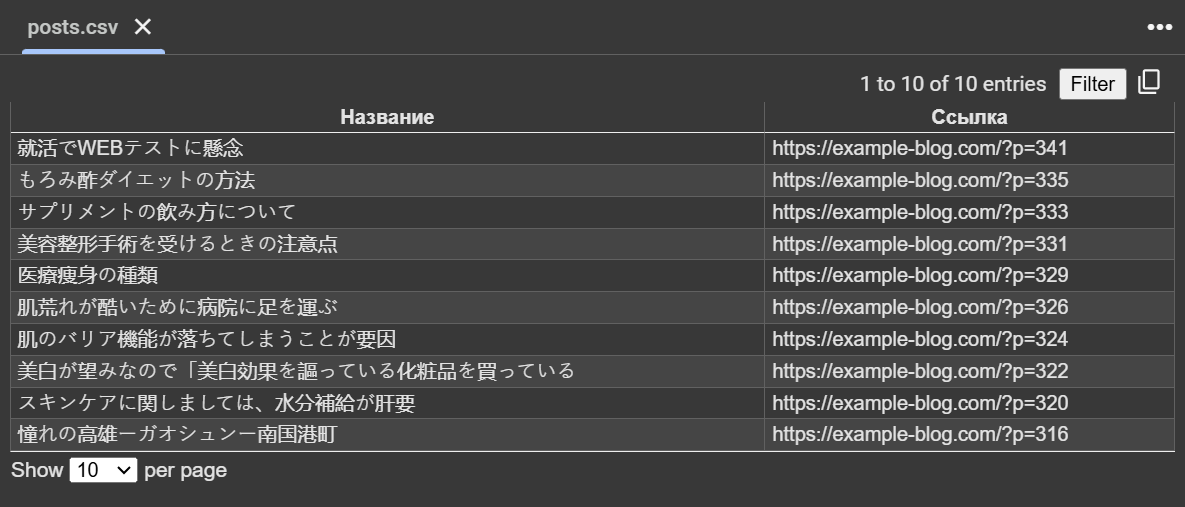

##Ансамбли

Сейчас век динамических веб-сайтов, все больше логики и вычислений приходится на сторону клиента (вашего браузера), а не на сторону сервера. Поэтому на практике часто приходится совмещать Selenium и Scrapy или другие библиотеки. Так получается достичь максимального эффекта: сложные интерактивные действия или выжидание полной загрузки контента достигаются с помощью Selenium, далее нужный контент высокопроизводительно разбирается, обрабатывается и сохраняется с помощью Scrapy.

Существует несколько подходов к комбинированию парсеров. Чаще всего Selenium пихают в Scrapy: это можно сделать на уровне паука или middleware.

##Легальность парсинга

Парсинг не является взломом информационной системы, мы так или иначе получаем доступ к контенту, который видим своими глазами. Проблемы могут начаться в зависимости от того, как мы **используем собранные данные**.

Если это закрытые данные, доступные по подписке, а мы их собрали и слили в интернет, то это может рассматриваться как нарушение авторского права. Сюда же относится ретрансляция открытых данных на своем ресурсе. Например, мы оперативно парсим несколько финансовых сайтов и выводим информацию на своем сайте. Вряд ли владельцы тех ресурсов, откуда мы забираем эту информацию, будут довольны, что пользователи приходят не к ним, а к нам.

Юридические вопросы обычно уточняются в ToS (Terms of Confitions, Условия использования). Например, социальная сеть X в [Условиях предоставления услуг](https://x.com/ru/tos) прямо пишет: *индексация поисковым роботом и веб-скрейпинг Сервисов без нашего предварительного письменного согласия прямо запрещены*. Еще одним местом, где владельцы ресурса могут сообщить о своем отношении к парсингу является специальный файл `robots.txt`. В этом файле указываются разделы сайта, которые доступны или закрыты для ботов (в т.ч. каких именно ботов). Это не юридический документ, поэтому решение о том, соблюдать правила или нет, остается за создателем парсера.

По общему правилу за сбор публичной информации не наступает никаких юридических последствий. Однако нужно помнить, что владельцы ресурса могут мешать парсингу, применяя блокировки и капчи. На своей стороне мы боремся с этим, подменяя IP-адрес, User Agent, выставляя задержки между запросами и т.д.

## Попугай дня

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Eclectus_roratus_-San_Diego-6.jpg/1920px-Eclectus_roratus_-San_Diego-6.jpg)

Это благородный зелено-красный попугай! Причем это самец, потому что у самки просто другая расцветка (и так легко определить, кто есть кто):

![](https://upload.wikimedia.org/wikipedia/commons/8/87/Eclectus_Parrot_%28Eclectus_roratus%29_-6-4c.jpg)

Из-за этого долгое время считали, что это разные виды попугаев)

На удивление довольно спокойные попугаи с шикарными перьями, которые живут до 50 лет. При этом они были непопулярными до 1980-х годов, но когда люди увидели такое красивое оперение, они стали очень популярными (еще за счет того, что к людям они достаточно хорошо привыкают), но при этом говорят они достаточно редко